<a href="https://colab.research.google.com/github/marcinwolter/MachineLearning-KISD-2025/blob/main/01_intro_nbconvert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to 🤗 Diffusers

Adapted from: https://github.com/huggingface/diffusion-models-class/tree/main/unit1

![diffusers_library](https://github.com/huggingface/diffusers/raw/main/docs/source/en/imgs/diffusers_library.jpg)

In [ ]:
#Installing pytorch with cuda 11.3 compatible with the old driver

#!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

In this notebook, you'll train your first diffusion model to **generate images of cute butterflies 🦋.** Along the way, you'll learn about the core components of the 🤗 Diffusers library, which will provide a good foundation for the more advanced applications that we'll cover later in the course.

Let's dive in!

## What You Will Learn

In this notebook you will:

- See a powerful custom diffusion model pipeline in action (with information on how to make your own version)
- Create your own mini pipeline by:
  - Recapping the core ideas behind diffusion models
  - Loading in data from the Hub for training
  - Exploring how we add noise to this data with a scheduler
  - Creating and training the UNet model
  - Putting the pieces together into a working pipeline
- Edit and run a script for initializing longer training runs, that will handle
  - Multi-GPU training via 🤗 Accelerate
  - Experiment logging to track critical stats
  - Uploading the final model to the Hugging Face Hub

❓If you have any questions, please post them on the `#diffusion-models-class` channel on the Hugging Face Discord server. If you haven't signed up yet, you can do so here: https://huggingface.co/join/discord

## Prerequisites

Before diving into the notebook, you should:

* 📖 Read the Unit 1 materials
* 🤗 Create an account on the Hugging Face Hub. If you haven't done so yet, you can do so here: https://huggingface.co/join

## Step 1: Setup

Run the following cell to install the diffusers library as well as a few other requirements:

In [ ]:
#%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0
#!pip list

Then you need to install Git-LFS to upload your model checkpoints:

In [ ]:
%%capture
###!sudo apt -qq install git-lfs
!git config --global credential.helper store

Finally, let's import the libraries we'll be using and define a few convenience functions which we'll use later in the notebook:

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)

    x = x.cpu()
    #normalize each image
    x = x.numpy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            min_val = np.min(x[i,j,:,:])
            max_val = np.max(x[i,j,:,:])
            x[i,j,:,:] = (x[i,j,:,:] - min_val)/(max_val - min_val)

    # and back to pytorch tensor
    x = torch.from_numpy(x)




    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=128):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#device = "cpu"
print("Device = ",device)

Device =  cuda


OK, we're all set!

## Step 2: Download a training dataset

For this example, we'll use a dataset of images from the Hugging Face Hub. Specifically, [this collection of 1000 butterfly pictures](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset). This is a very small dataset, so we've also included commented out lines for a few larger options. If you'd prefer to use your own collection of images, you can also use the commented-out code example to load in pictures from a folder instead.

In [ ]:
import torchvision
from datasets import load_dataset
from torchvision import transforms
#from torchvision.transforms import v2



#dataset = load_dataset("huggan/smithsonian_butterflies_subset", split='train[:1000]')


# Or load images from a local folder
#dataset = load_dataset("imagefolder", data_dir="/workspace/datasets/celeba_hq_256/", split='train[:1500]')
dataset = load_dataset("imagefolder", data_dir="/storage/MUonE/mwolter/img_align_celeba", split='train[:2500]')


print("X shape:", dataset)
xb = next(iter(dataset))["image"]
print("X shape:", xb)
#show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 64 #128 #32 #64
# You can lower your batch size if you're running out of GPU memory
batch_size = 64 #64

# Define data augmentations
'''
preprocess = v2.Compose(
    [
        #v2.RandomPhotometricDistort(),
        v2.RandomGrayscale(0.9999),
        #v2.RandomZoomOut(side_range=(1.0,1.2),p=0.5),
        v2.RandomRotation(20, fill=0),
        #v2.AutoAugment(fill=255, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
        v2.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        v2.Resize((image_size, image_size)),  # Resize
        v2.ToTensor(),  # Convert to tensor (0, 1)
        v2.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
'''
preprocess = transforms.Compose(
    [
        #v2.RandomPhotometricDistort(),
        transforms.RandomGrayscale(0.9999),
        #transforms.RandomCrop(size=(230,310)),
        ###transforms.RandomRotation(9, fill=0),
        #v2.AutoAugment(fill=255, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)
'''
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)
'''

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

/home/gpu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Resolving data files: 100%|████████| 202599/202599 [00:00<00:00, 682539.60it/s]


X shape: Dataset({
    features: ['image'],
    num_rows: 2500
})
X shape: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x7F4AA09318D0>


We can grab a batch of images and view some of them like so:

X shape: torch.Size([8, 3, 64, 64])


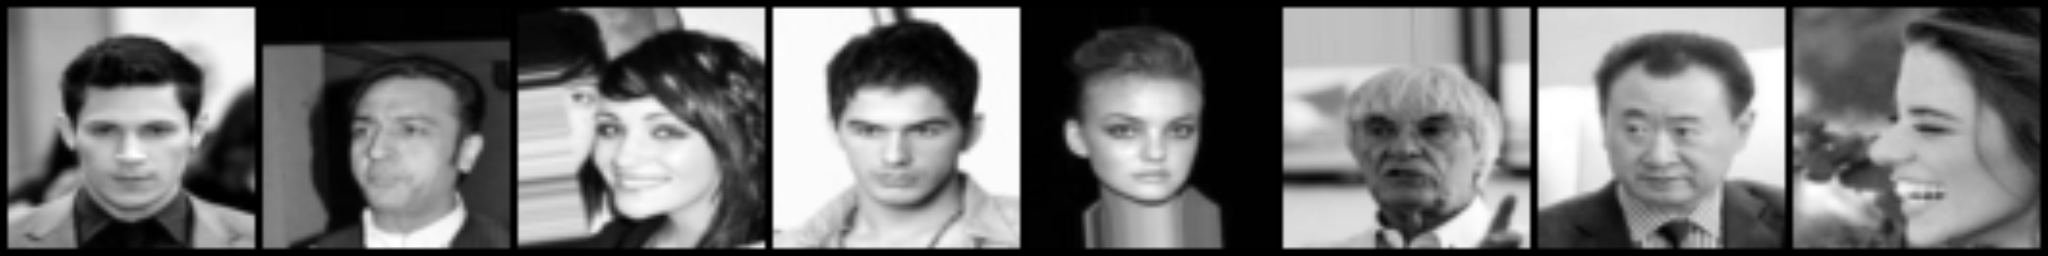

In [ ]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 256, 256), resample=Image.BILINEAR)

We're sticking to a small dataset with 32 pixel images to keep training times manageable in this notebook.

## Step 3: Define the Scheduler

Our plan for training is to take these input images and add noise to them, then feed the noisy images to the model. And during inference, we will use the model predictions to iteratively remove noise. In `diffusers`,  these processes are both handled by the **scheduler**.

The noise schedule determines how much noise is added at different timesteps. Here's how we might create a scheduler using the default settings for 'DDPM' training and sampling (based on the paper ["Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239)):

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. Now, we don't necessarily want to do this operation 500 times to get $x_{500}$ so we have another formula to get $x_t$ for any t given $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

The maths notation always looks scary! Luckily the scheduler handles all that for us. We can plot $\sqrt{\bar{\alpha}_t}$ (labelled as `sqrt_alpha_prod`) and $\sqrt{(1 - \bar{\alpha}_t)}$ (labelled as `sqrt_one_minus_alpha_prod`) to view how the input (x) and the noise are scaled and mixed across different timesteps:

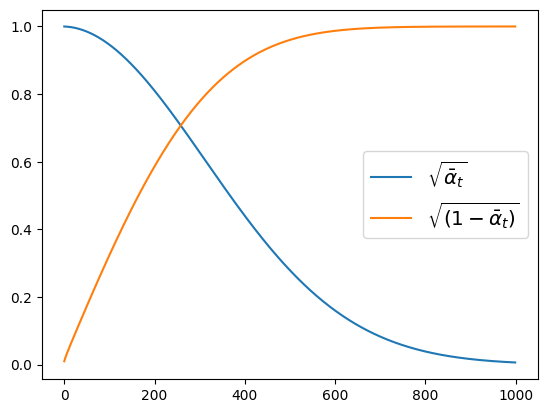

In [ ]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

**Exercise:** You can explore how this plot changes with different settings for beta_start, beta_end and beta_schedule by swapping in one of the commented-out options here:

In [ ]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

Whichever scheduler you've chosen, we can now use it to add noise in different amounts using the `noise_scheduler.add_noise` function like so:

Noisy X shape torch.Size([8, 3, 64, 64])


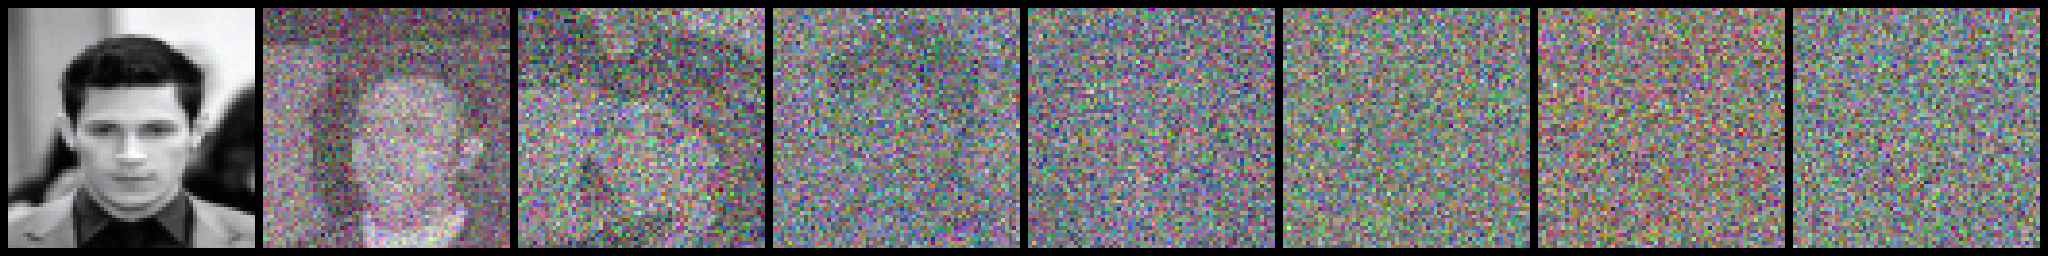

In [ ]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 256, 256), resample=Image.NEAREST)

Again, explore the effect of using different noise schedules and parameters here. [This video](https://www.youtube.com/watch?v=fbLgFrlTnGU) does a great job explaining some of the maths above in more detail, and is a great introduction to some of these concepts.

## Step 4: Define the Model

Now we come to the core component: the model itself.

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:
- the model has the input image go through several blocks of ResNet layers, each of which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downsample path to the corresponding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size.
Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram):

In [ ]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256, 256),
    #(64, 64, 128, 256, 512, 1024), #(128, 256, 256, 512),   #(64, 128, 128, 256), #, 512),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

When dealing with higher-resolution inputs you may want to use more down and up-blocks, and keep the attention layers only at the lowest resolution (bottom) layers to reduce memory usage. We'll talk later about how you might experiment to find the best settings for your use-case.

We can check that passing in a batch of data and some random timesteps produces an output the same shape as the input data:

In [ ]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 64, 64])

In the next section we'll see how to train this model.

## Step 5: Create a Training Loop

Time to train! Below is a typical optimization loop in PyTorch, where we run through the data batch by batch and update the parameters of our model each step using an optimizer - in this case the AdamW optimizer with a learning rate of 0.0004.

For each batch of data, we
- Sample some random timesteps
- Noise the data accordingly
- Feed the noisy data through the model
- Compare the model predictions with the target (i.e. the noise in this case) using mean squared error as our loss function
- Update the model parameters via `loss.backward()` and `optimizer.step()`

During this process we also log the losses over time for later plotting.

NB: This code takes nearly 10 minutes to run - feel free to skip these two cells and use the pretrained model if you are in a hurry. Alternatively, you can explore how reducing the number of channels in each layer via the model definition above can speed things up.

The [official diffusers training example](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb) trains a larger model on this dataset at higher resolution, and is a good reference for what a less minimal training loop looks like:

/home/gpu/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:50, loss: 0.07132526952773333
Epoch:100, loss: 0.050538554042577746
Epoch:150, loss: 0.04527432289905846
Epoch:200, loss: 0.03555882037617266
Epoch:250, loss: 0.03332654926925897
Epoch:300, loss: 0.031761003844439986
Epoch:350, loss: 0.029602284776046872
Epoch:400, loss: 0.029968934366479516


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.51it/s]


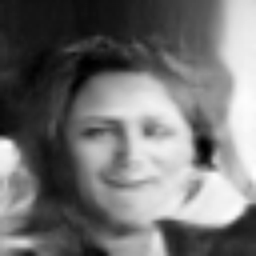

Epoch:450, loss: 0.02788910227827728
Epoch:500, loss: 0.026824156241491436
Epoch:550, loss: 0.030318360263481735
Epoch:600, loss: 0.028432282665744425
Epoch:650, loss: 0.026467321533709766
Epoch:700, loss: 0.025991842290386556
Epoch:750, loss: 0.02791172810830176
Epoch:800, loss: 0.024702638387680054


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.82it/s]


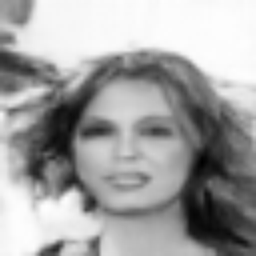

Epoch:850, loss: 0.023284214292652906
Epoch:900, loss: 0.022730755247175695
Epoch:950, loss: 0.02464263259898871
Epoch:1000, loss: 0.02380548007786274
Epoch:1050, loss: 0.02361393002793193
Epoch:1100, loss: 0.021011161559727043
Epoch:1150, loss: 0.022471349756233393
Epoch:1200, loss: 0.02058611756656319


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 74.01it/s]


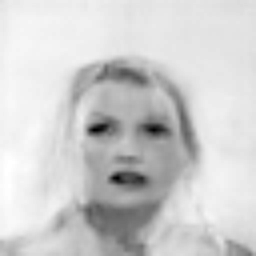

Epoch:1250, loss: 0.020006893062964083
Epoch:1300, loss: 0.02070082095451653
Epoch:1350, loss: 0.021611624909564853
Epoch:1400, loss: 0.019527561450377106
Epoch:1450, loss: 0.019850638206116857
Epoch:1500, loss: 0.0199066931148991
Epoch:1550, loss: 0.01906742857536301
Epoch:1600, loss: 0.018440734106115998


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.58it/s]


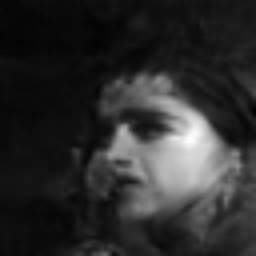

Epoch:1650, loss: 0.0195739206741564
Epoch:1700, loss: 0.018976811389438807
Epoch:1750, loss: 0.01900811295490712
Epoch:1800, loss: 0.017595676914788784
Epoch:1850, loss: 0.018374932743608952
Epoch:1900, loss: 0.01793627270963043
Epoch:1950, loss: 0.017567352013429627
Epoch:2000, loss: 0.017095329985022546


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.68it/s]


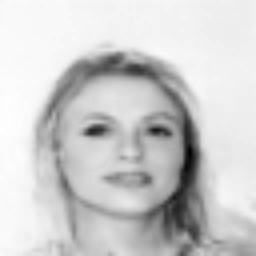

Epoch:2050, loss: 0.017668917658738792
Epoch:2100, loss: 0.01776731952559203
Epoch:2150, loss: 0.017648450401611625
Epoch:2200, loss: 0.01736789180431515
Epoch:2250, loss: 0.018010638700798155
Epoch:2300, loss: 0.016954325465485455
Epoch:2350, loss: 0.0163928211084567
Epoch:2400, loss: 0.020588801125995815


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.48it/s]


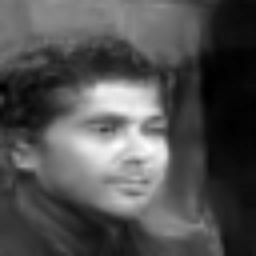

Epoch:2450, loss: 0.01762675486970693
Epoch:2500, loss: 0.016364830447128043
Epoch:2550, loss: 0.016822866885922848
Epoch:2600, loss: 0.01691363106947392
Epoch:2650, loss: 0.01503127800533548
Epoch:2700, loss: 0.01734093010891229
Epoch:2750, loss: 0.01756198313087225
Epoch:2800, loss: 0.0178320832317695


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.57it/s]


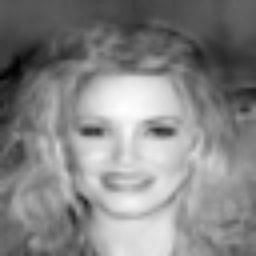

Epoch:2850, loss: 0.015930888499133287
Epoch:2900, loss: 0.01609924731310457
Epoch:2950, loss: 0.015196514781564474
Epoch:3000, loss: 0.014395028952276335
Epoch:3050, loss: 0.01564372192369774
Epoch:3100, loss: 0.018300343328155576
Epoch:3150, loss: 0.015073913417290896
Epoch:3200, loss: 0.019968778267502783


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.88it/s]


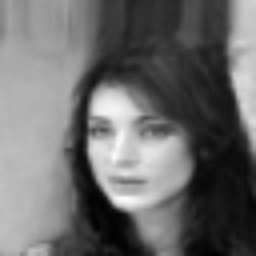

Epoch:3250, loss: 0.013720217277295887
Epoch:3300, loss: 0.01452162569621578
Epoch:3350, loss: 0.016932328580878675
Epoch:3400, loss: 0.01636512300465256
Epoch:3450, loss: 0.01527868511620909
Epoch:3500, loss: 0.013944796973373742
Epoch:3550, loss: 0.014540299691725522
Epoch:3600, loss: 0.01502706769388169


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.71it/s]


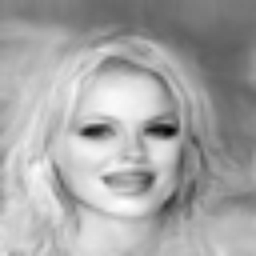

Epoch:3650, loss: 0.014907545736059546
Epoch:3700, loss: 0.014145145693328231
Epoch:3750, loss: 0.015070670912973583
Epoch:3800, loss: 0.01403306012507528
Epoch:3850, loss: 0.015684403665363788
Epoch:3900, loss: 0.014284883299842477
Epoch:3950, loss: 0.014064255193807185
Epoch:4000, loss: 0.014292689552530647


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.49it/s]


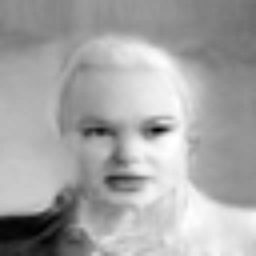

Epoch:4050, loss: 0.022842366714030504
Epoch:4100, loss: 0.01508296829997562
Epoch:4150, loss: 0.01445363329257816
Epoch:4200, loss: 0.015456807124428451
Epoch:4250, loss: 0.013893979042768479
Epoch:4300, loss: 0.01588075328618288
Epoch:4350, loss: 0.013864807004574686
Epoch:4400, loss: 0.01358747020130977


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.70it/s]


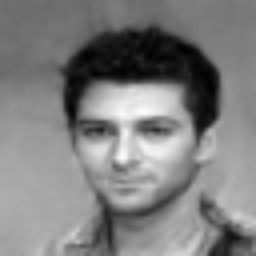

Epoch:4450, loss: 0.014570443774573505
Epoch:4500, loss: 0.015783358761109412
Epoch:4550, loss: 0.013429310882929712
Epoch:4600, loss: 0.014057598076760769
Epoch:4650, loss: 0.01230073322658427
Epoch:4700, loss: 0.013141519040800631
Epoch:4750, loss: 0.013041912845801562
Epoch:4800, loss: 0.015015789889730513


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.84it/s]


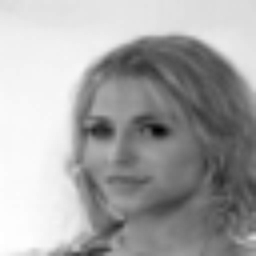

Epoch:4850, loss: 0.012944095907732845
Epoch:4900, loss: 0.013752190978266299
Epoch:4950, loss: 0.01561246276833117
Epoch:5000, loss: 0.0159435432869941
Epoch:5050, loss: 0.013492699922062456
Epoch:5100, loss: 0.01344830384477973
Epoch:5150, loss: 0.013010947674047202
Epoch:5200, loss: 0.011748816329054534


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.68it/s]


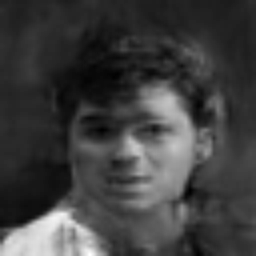

Epoch:5250, loss: 0.012760685966350138
Epoch:5300, loss: 0.013844757596962154
Epoch:5350, loss: 0.012729215086437762
Epoch:5400, loss: 0.012488904118072242
Epoch:5450, loss: 0.015334313921630382
Epoch:5500, loss: 0.014003965677693487
Epoch:5550, loss: 0.013449402945116162
Epoch:5600, loss: 0.016259587625972925


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.71it/s]


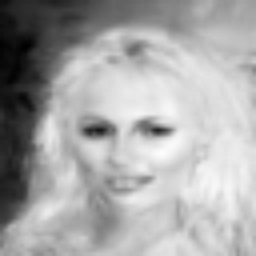

Epoch:5650, loss: 0.013654777081683278
Epoch:5700, loss: 0.011535847303457558
Epoch:5750, loss: 0.0131432703579776
Epoch:5800, loss: 0.015227382513694465
Epoch:5850, loss: 0.013684571511112154
Epoch:5900, loss: 0.012052812939509749
Epoch:5950, loss: 0.010899274912662803
Epoch:6000, loss: 0.011630135821178555


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.85it/s]


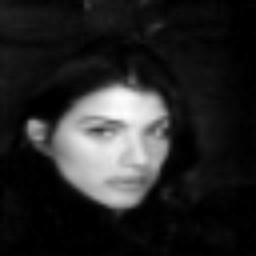

Epoch:6050, loss: 0.012399393203668296
Epoch:6100, loss: 0.01338786615524441
Epoch:6150, loss: 0.013261982076801359
Epoch:6200, loss: 0.01103471127571538
Epoch:6250, loss: 0.015993273863568903
Epoch:6300, loss: 0.01300566828576848
Epoch:6350, loss: 0.011282973864581436
Epoch:6400, loss: 0.011542687530163676


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.66it/s]


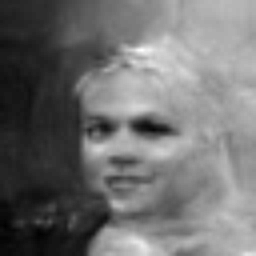

Epoch:6450, loss: 0.0119210566743277
Epoch:6500, loss: 0.012221226084511727
Epoch:6550, loss: 0.012373106006998568
Epoch:6600, loss: 0.01397094875574112
Epoch:6650, loss: 0.011640005890512839
Epoch:6700, loss: 0.011779233580455184
Epoch:6750, loss: 0.01066355489892885
Epoch:6800, loss: 0.011562743259128183


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.23it/s]


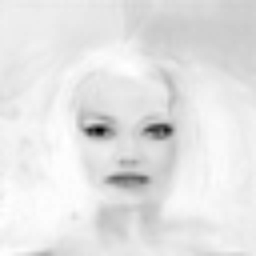

Epoch:6850, loss: 0.011807692318689078
Epoch:6900, loss: 0.013173681544139981
Epoch:6950, loss: 0.012069255660753698
Epoch:7000, loss: 0.012235189706552773
Epoch:7050, loss: 0.011704851838294417
Epoch:7100, loss: 0.012695842364337295
Epoch:7150, loss: 0.013093993254005908
Epoch:7200, loss: 0.013018373667728156


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.34it/s]


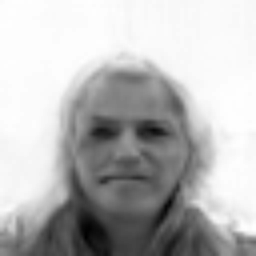

Epoch:7250, loss: 0.011315262061543763
Epoch:7300, loss: 0.010575204866472631
Epoch:7350, loss: 0.012188428128138185
Epoch:7400, loss: 0.012668329023290426
Epoch:7450, loss: 0.011908783786930143
Epoch:7500, loss: 0.013744722446426749


In [ ]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) #lr=4e-4)

losses = []

for epoch in range(7500):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 50 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

    # show an image every 50 epochs
    if (epoch + 1) % 400 == 0:
        # Set the noise scheduler
        noise_scheduler = DDPMScheduler(
            num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
        )
        from diffusers import DDPMPipeline
        image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

        from PIL import Image, ImageOps, ImageEnhance

        pipeline_output = image_pipe()
        img = ImageOps.grayscale(pipeline_output.images[0].resize((256,256), resample=Image.Resampling.BILINEAR ))
        img = ImageOps.autocontrast(img)
        img.show()


Plotting the loss, we see that the model rapidly improves initially and then continues to get better at a slower rate (which is more obvious if we use a log scale as shown on the right):

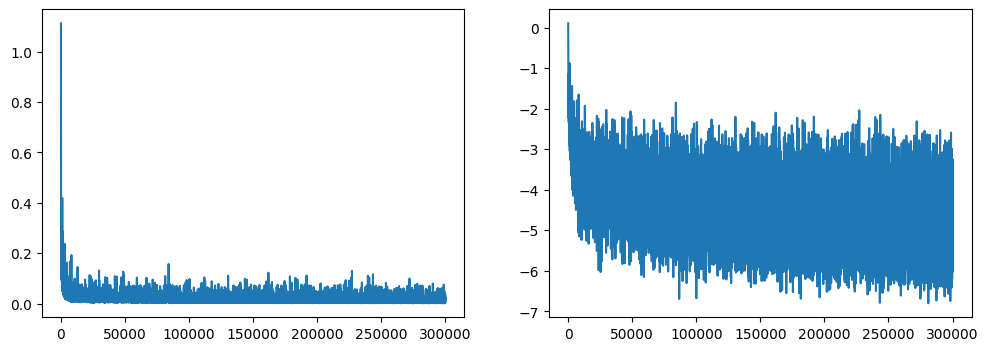

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

As an alternative to running the training code above, you can use the model from the pipeline like so:

In [ ]:
# Uncomment to instead load the model I trained earlier:
# model = butterfly_pipeline.unet

## Step 6: Generate Images

How do we get images with this model?

### Option 1: Creating a pipeline:

In [ ]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.34it/s]


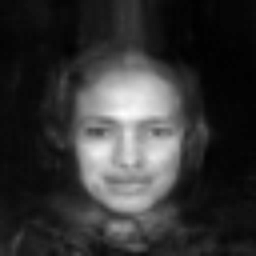

<class 'list'> 1
ImagePipelineOutput(images=[<PIL.Image.Image image mode=RGB size=64x64 at 0x7F4A9F6B9480>])


In [ ]:
from PIL import Image, ImageOps, ImageEnhance

pipeline_output = image_pipe()
img = ImageOps.grayscale(pipeline_output.images[0].resize((256,256), resample=Image.Resampling.BILINEAR ))
img = ImageOps.autocontrast(img)
img.show()
print(type(pipeline_output.images),len(pipeline_output.images))
print(pipeline_output)


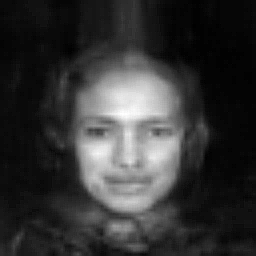

In [ ]:

# Enhance Sharpness
curr_sharp = ImageEnhance.Sharpness(img)
new_sharp = 4

# Sharpness enhanced by a factor of 4
img_sharped = curr_sharp.enhance(new_sharp)
img_sharped = ImageOps.autocontrast(img_sharped)

# shows updated image in image viewer
img_sharped.show()

100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 73.48it/s]


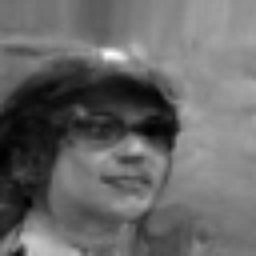

<class 'list'> 1
ImagePipelineOutput(images=[<PIL.Image.Image image mode=RGB size=64x64 at 0x7F4AA0981D50>])


In [ ]:
pipeline_output = image_pipe()
img = ImageOps.grayscale(pipeline_output.images[0].resize((256,256), resample=Image.Resampling.BILINEAR ))
img = ImageOps.autocontrast(img)
img.show()
print(type(pipeline_output.images),len(pipeline_output.images))
print(pipeline_output)

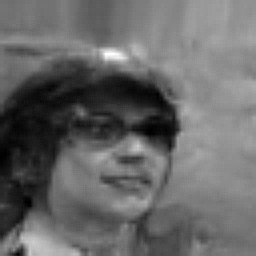

In [ ]:

# Enhance Sharpness
curr_sharp = ImageEnhance.Sharpness(img)
new_sharp = 4

# Sharpness enhanced by a factor of 4
img_sharped = curr_sharp.enhance(new_sharp)
img_sharped = ImageOps.autocontrast(img_sharped)

# shows updated image in image viewer
img_sharped.show()

We can save a pipeline to a local folder like so:

In [ ]:

#image_pipe.save_pretrained("my_pipeline")

Inspecting the folder contents:

In [ ]:
!ls my_pipeline/

ls: cannot access 'my_pipeline/': No such file or directory


The `scheduler` and `unet` subfolders contain everything needed to re-create those components. For example, inside the `unet` folder you'll find the model weights (`diffusion_pytorch_model.bin`) alongside a config file which specifies the UNet architecture.

In [ ]:
!ls my_pipeline/unet/

ls: cannot access 'my_pipeline/unet/': No such file or directory


Together, these files contain everything needed to recreate the pipeline. You can manually upload them to the hub to share the pipeline with others, or check out the code to do this via the API in the next section.

### Option 2: Writing a Sampling Loop

If you inspect the forward method of the pipeline you'll be able to see what is happening when we run `image_pipe()`:

In [ ]:
# ??image_pipe.forward

We begin with random noise, and run through the scheduler timesteps from most to least noisy, removing a small amount of noise each step based on the model prediction:

In [ ]:
# Random starting point (16 random images):
sample = torch.randn(16, 3, 64, 64).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample


<class 'torch.Tensor'> torch.Size([16, 3, 64, 64])


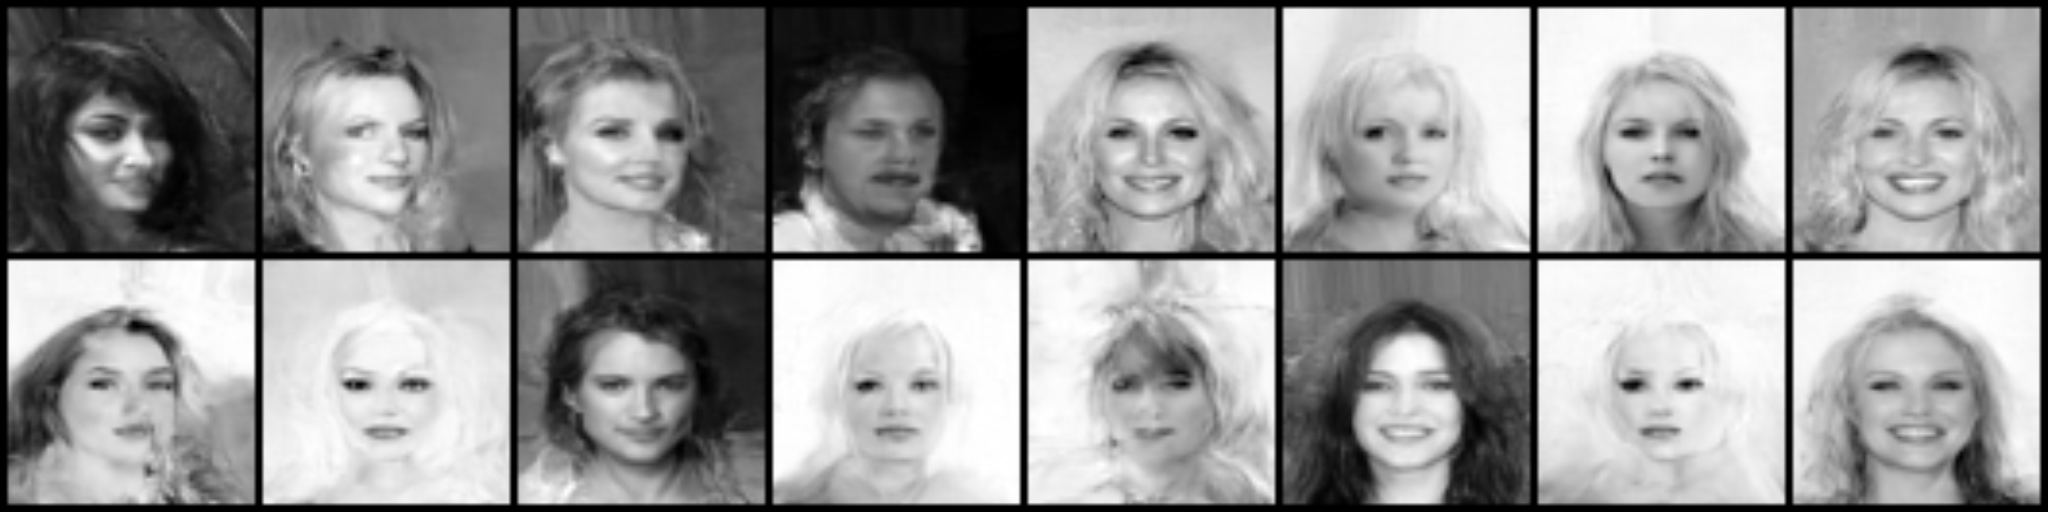

In [ ]:
print(type(sample), sample.shape)
ImageOps.grayscale(show_images(sample).resize((8 * 256, 2 * 256), resample=Image.Resampling.BILINEAR))

The `noise_scheduler.step()` function does the maths required to update `sample` appropriately. There are a number of sampling methods - in the next unit we'll see how we can swap in a different sampler to speed up image generation with existing models, and talk more about the theory behind sampling from diffusion models.